Before running the project, please download the GTZAN Dataset - Music Genre Classification for training the audio recognition model from [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification).

After downloading, move the ‘genres_original’ folder into data directory.


  0%|          | 0/2 [00:00<?, ?it/s]

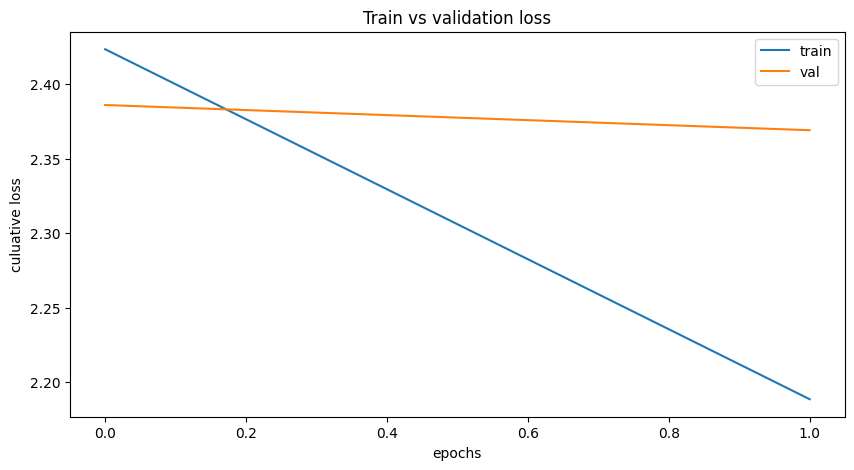

In [12]:
%matplotlib inline

import pandas as pd
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio.transforms as transforms

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from src.audio_folder_dataset import AudioFolder
from tqdm.auto import tqdm  
from src.audio_folder_collate_fn import collate_audio_folder_batch

device = 'cpu'
#sample rate for the speech commands dataset'
original_sample_rate = 16000 
#sample rate for the speech commands dataset
new_sample_rate = 8000 
#size of validation split
val_size = 0.3  
#batch size for training
batch_size = 200 
#number of epochs for training
num_epochs = 2 
#earning rate for training 
learning_rate = 0.01
#weight decay for ADAM optimiser
weight_decay = 0.0001 

#define data transform
transform = transforms.Resample(orig_freq=original_sample_rate, new_freq=new_sample_rate)

train_path = 'data/genres_original' 
#load audio label information from a file
genres_df = pd.read_csv('data/features_30_sec.csv')
#create a dictionary mapping filenames to their corresponding genre labels for easy lookup,ref:https://pandas.pydata.org/docs/reference/api/pandas.Series.to_dict.html
genre_dict = pd.Series(genres_df.label.values, index=genres_df.filename).to_dict()

#create dataset
dataset = AudioFolder(train_path, transform=transform)

#get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))
#get train / val split for data points
train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

#vverride dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

#define a custom data loading function custom_collate_fn to perform custom processing on batches during data loading
def custom_collate_data(batch):
    #calculate the maximum length of samples in each batch
    target_channels = 2
    #find the maximum length of the audio samples in the batch to pad all samples to the same length,ref:https://fabridamicelli.github.io/posts/2023-09-13-pytorch-dataloader-collate.html
    max_length = max(sample[0].shape[1] for sample in batch)
    #create an empty list to store padded batches
    collate_batch = []
    #iterate through each sample in the batch
    for (data, target) in batch:        
        #if the number of channels in the data is less than the target channels, repeat the data to match the target channels
        if data.shape[0] < target_channels:
            data = data.repeat(target_channels // data.shape[0], 1)     
       #if the length of the data is less than the maximum length of samples in the batch, pad the data
        if data.shape[1] < max_length:
            padding_size = max_length - data.shape[1]
            data = F.pad(data, (0, padding_size), "constant", 0)
        
        collate_batch.append((data, target))
    
    #add padded data samples to the padded batch list,ref:https://tuongtranngoc.github.io/posts/2023/collate_fn/
    batch_data, batch_target = zip(*collate_batch)
    #convert these tuples into torch.Tensor format suitable for model training
    batch_data = torch.stack(batch_data, dim=0)
    batch_target = torch.tensor(batch_target, dtype=torch.long)
    return batch_data, batch_target

#create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, collate_fn=custom_collate_data, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, collate_fn=custom_collate_data, shuffle=False)

class M5(nn.Module):
    def __init__(self, n_input=2, n_output=11, stride=16, n_channel=32):
        super().__init__()
        #first convolutional layer
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        #batch normalization
        self.bn1 = nn.BatchNorm1d(n_channel)
        #max pooling
        self.pool1 = nn.MaxPool1d(4, 4)
        #second convolutional layer
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        #batch normalization
        self.bn2 = nn.BatchNorm1d(n_channel)
        #max pooling
        self.pool2 = nn.MaxPool1d(4)
        #third convolutional layer
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        #batch normalization
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        #max pooling
        self.pool3 = nn.MaxPool1d(4)
        #fully connected layer
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        #reLU activation function after batch normalization
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x)) 
        x = self.pool3(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        #squeeze the second dimension
        x = torch.squeeze(x, 1) 
        return x

#instantiate the model object and move the model to the specified device
model = M5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
#define the loss function
criterion = nn.CrossEntropyLoss()

#calculate the progress bar update step
pbar_update = 1 / (len(train_loader) + len(val_loader))

#initialize the loss tracking lists
train_losses = []
val_losses = []
#initialize the best loss
best_loss = 100000

#create progress bars using tqdm, where the total number of updates equals the epochs multiplied by the sum of the lengths of train_loader and val_loader
with tqdm(total=num_epochs) as pbar:

    # For each cycle of the dataset
    for epoch in range(num_epochs):
        # Put model in training model
        model.train()
        total_train_loss = 0.0
        # Train loop
        # For each batch in one cycle of the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to whatever device we are running training on
            data, target = data.to(device), target.to(device)
            # Forward pass with the model
            output = model(data)
            # Evaluate classification accuracy
            loss = criterion(output, target)
            # Backpropagate loss and update gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Keep track off loss over time
            total_train_loss += loss.item()
            
            # update progress bar
            pbar.update(pbar_update)

        #put model in evaluation mode (turn off batch norm)
        model.eval()
        total_val_loss = 0.0
        # Without gradient tracking
        with torch.no_grad():
            # Variable to track total correct classifications
            correct = 0
            # For each batch in one cycle of the validation set
            for data, target in val_loader:
                 # Move data to whatever device we are running training on
                data, target = data.to(device), target.to(device)
                # Forward pass with the model
                output = model(data)
                # Reshape target to match the expected shape of CrossEntropyLoss
                target_one_hot = F.one_hot(target, num_classes=11).float()
                # Evaluate classification accuracy
                loss = criterion(output, target)
                # Track loss
                total_val_loss += loss.item()
                # update progress bar
                pbar.update(pbar_update)
        # Normalise cumulative losses to dataset size
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        # Added cumulative losses to lists for later display
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pbar.set_description(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')     
         # if validation score is lowest so far, save the model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_audio_classifier.pt')

#visualize training and validation losses
plt.figure(figsize=(10, 5))
plt.title('Train vs validation loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel("epochs")
plt.ylabel("culuative loss")
plt.legend()
plt.show()

In [7]:
class M5(nn.Module):
    def __init__(self, n_input=2, n_output=11, stride=16, n_channel=32):
        super().__init__()
        #first convolutional layer
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        #batch normalization
        self.bn1 = nn.BatchNorm1d(n_channel)
        #max pooling
        self.pool1 = nn.MaxPool1d(4, 4)
        #second convolutional layer
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        #batch normalization
        self.bn2 = nn.BatchNorm1d(n_channel)
        #max pooling
        self.pool2 = nn.MaxPool1d(4)
        #third convolutional layer
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        #batch normalization
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        #max pooling
        self.pool3 = nn.MaxPool1d(4)
        #fully connected layer
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        #reLU activation function after batch normalization
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x)) 
        x = self.pool3(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        #squeeze the second dimension
        x = torch.squeeze(x, 1) 
        return x
    
#load the trained model
model = M5() 
model.load_state_dict(torch.load('best_audio_classifier.pt'))
#set the model to evaluation mode
model.eval() 

#audio preprocessing function
def preprocess_audio(file_path):
    #load the audio file and get waveform and sample rate using torchaudio，ref:https://stackoverflow.com/questions/71108331/torchaudio-load-audio-with-specific-sampling-rate
    waveform, sample_rate = torchaudio.load(file_path)
    #perform appropriate transformations based on model requirements
    new_sample_rate = 8000
    transform = transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
    waveform = transform(waveform)
    #ensure the waveform has two channels
    if waveform.shape[0] == 1:
        waveform = torch.cat([waveform, waveform], dim=0) 
    return waveform

def classify_audio(file_path):
    #disables gradient calculation to save memory and computations,ref:https://discuss.pytorch.org/t/question-about-use-of-torch-max-function-to-calculate-accuracy/187500
    with torch.no_grad():
        #initialize variables for correctness and total predictions
        total = 0
        #load and preprocess the audio file
        waveform = preprocess_audio(file_path)
        #add a batch dimension to match model input
        waveform = waveform.unsqueeze(0)
        #pass the processed waveform through the model
        outputs = model(waveform)
        #find the class with the highest probability
        _, predicted = torch.max(outputs, 1)
        #increment total predictions
        total += 1
        #return the predicted class index as an integer
        return predicted.item()

test_audio_file_path = 'data/genres_original/blues/blues.00000.wav'
labels_df = pd.read_csv('data/features_3_sec.csv')
index_label = dict(enumerate(labels_df['label']))

#perform classification using the model
predicted_genre_index = classify_audio(test_audio_file_path)
#get the predicted label name from the dictionary
predicted_genre_label = index_label[predicted_genre_index]
print(f"Predicted genre: {predicted_genre_label}")

Predicted genre: blues
